<h1 style="font-size:2.0em; font-weight:bold; text-align:center;">Model Training </h1>

This project is a **Proof of Concept (PoC)** aimed at detecting potential financial crimes using **anomaly scoring** techniques. It reflects my growing interest in financial crime prevention, particularly in the context of evolving geopolitical risks.

The dataset spans from **April 2, 2025** to **April 4, 2025**, based on the assumption that in mid-2025, trade tensions lead to increased abnormal or suspicious transaction activities.

- Feature Scaling
- Model Training: Isolation Forest, Autoencoder  
- Evaluation: Precision-Recall, ROC-AUC, confusion matrix, feature importance  

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px
%matplotlib inline
from sklearn.ensemble import IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
X_train = pd.read_csv('data/CLEAN_transaction_monitoring_merged_X_TRAIN.csv', index_col=0)
X_test = pd.read_csv('data/CLEAN_transaction_monitoring_merged_X_TEST.csv', index_col=0)
print (X_train.shape)
print (X_test.shape)

y_train = pd.read_csv('data/CLEAN_transaction_monitoring_merged_with_fraud_Y_TRAIN.csv')
y_test = pd.read_csv('data/CLEAN_transaction_monitoring_merged_with_fraud_Y_TEST.csv')

print (y_train.shape)
print (y_test.shape)

(7426, 87)
(3183, 87)
(7426, 1)
(3183, 1)


In [3]:
y_test.value_counts()

is_fraud
0           3119
1             64
Name: count, dtype: int64

In [4]:
#feature_cols = df.columns.drop('is_fraud')
#corr_values = df[feature_cols].corr()

#tril_index = np.tril_indices_from(corr_values)

#for coord in zip(*tril_index):
#    corr_values.iloc[coord[0], coord[1]] = np.nan
    
# Stack the data and convert to a data frame
#orr_values = (corr_values
               #.stack()
               #.to_frame()
               #.reset_index()
               #.rename(columns={'level_0':'feature1',
                                #'level_1':'feature2',
                                #0:'correlation'}))

# Get the absolute values for sorting
#corr_values['abs_correlation'] = corr_values.correlation.abs()

In [5]:
#plt.figure(figsize=(12,10))
#sns.histplot(corr_values['abs_correlation'], bins=20)
#plt.xlabel('Absolute Correlation')
#plt.ylabel('Frequency')
#plt.show()

In [6]:
#corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

When we see that all independent variables are highly correlated, we may want to perform feature selection.

In [7]:
#def remove_highly_correlated_features(df, threshold=0.99):
    #corr_matrix = df[feature_cols].corr().abs()
    #to_drop = set()
    #for i in range(len(corr_matrix.columns)):
        #col = corr_matrix.columns[i]
        #if col in to_drop:
            #continue
        #for j in range(i + 1, len(corr_matrix.columns)):
            #other_col = corr_matrix.columns[j]
            #if corr_matrix.iloc[i, j] > threshold:
                #to_drop.add(other_col)
    #return df.drop(columns=list(to_drop))
 
#data = remove_highly_correlated_features(df[feature_cols], threshold=1.0)

In [8]:
#data.shape[1]

## <h2 style="font-size: 1.8em; font-weight: bold;"> Baseline Model Training </h2>

In [9]:
iso_forest = IsolationForest(n_estimators=100, contamination='auto', max_features=1.0, random_state=42)
iso_forest.fit(X_train)
train_score = iso_forest.decision_function(X_train)
test_score = iso_forest.decision_function(X_test)
train_pred = iso_forest.predict(X_train)
test_pred = iso_forest.predict(X_test)

mapp_test_pred = {1: 0, -1: 1}
test_pred = [mapp_test_pred[p] for p in test_pred]

In [10]:
print("Classification Report for Isolation Forest:")
print(classification_report(y_test,test_pred, target_names=['Non-Fraud', 'Fraud'])) 

Classification Report for Isolation Forest:
              precision    recall  f1-score   support

   Non-Fraud       0.99      0.34      0.51      3119
       Fraud       0.02      0.75      0.04        64

    accuracy                           0.35      3183
   macro avg       0.50      0.55      0.28      3183
weighted avg       0.97      0.35      0.50      3183



Right now, the model struggles to catch fraud properly

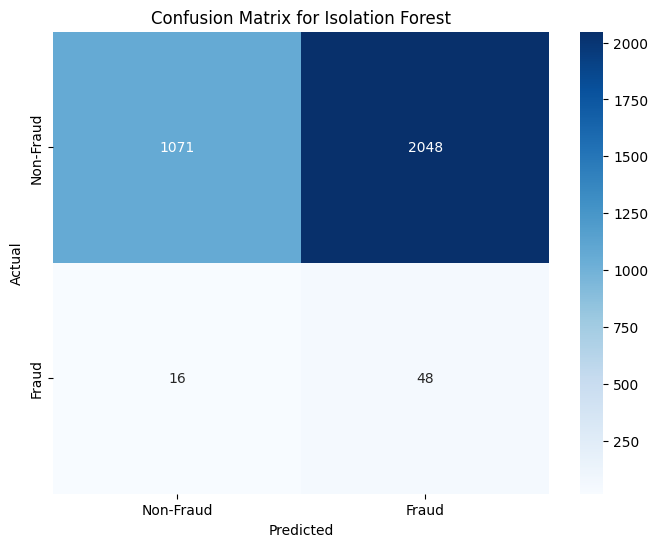

In [11]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_pred)  
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',    
            xticklabels=['Non-Fraud', 'Fraud'], 
            yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix for Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Too many false positives will lead to operational overload.

ROC AUC Score of Isolation Forest: 0.55


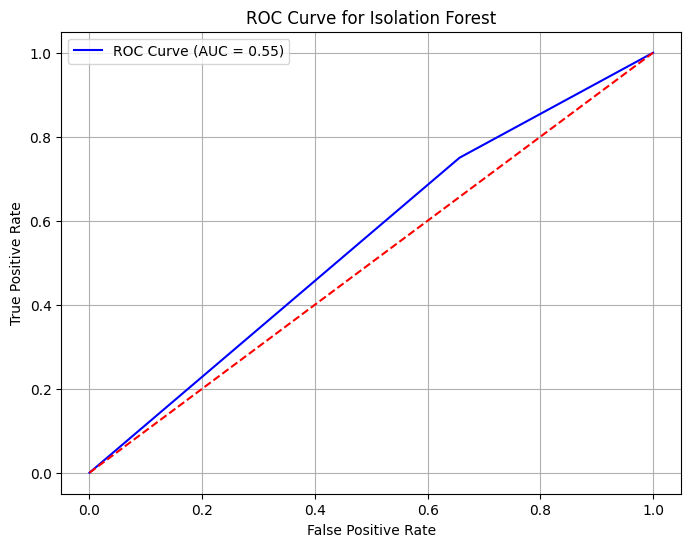

In [12]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, test_pred)
print(f"ROC AUC Score of Isolation Forest: {roc_auc:.2f}")
# Plotting the ROC curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, test_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('ROC Curve for Isolation Forest') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

So currently, the model is more like a random guess, with a ROC AUC score of 0.55.